In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import matplotlib as mpl
from os import listdir
from scipy.spatial.distance import pdist, squareform

rcParams = {'font.size': 24 , 'font.weight': 'bold', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal', 'lines.linewidth':3}
plt.rcParams.update(rcParams)

def Bray_Curtis(X, Y):
    C = np.minimum(X, Y)
    return 1 - (2*C.sum()/(X.sum() + Y.sum()))

def Canberra(X, Y):
    C = np.abs(X - Y)
    D = np.abs(X)+np.abs(Y)
    D[D == 0] = 1
    return (C/D).sum()

def Load_Coverage_Summary(data_dir, filter_list, log_transform = True):
    files = listdir(data_dir)
    df_Summary = pd.DataFrame()
    for f in files:
        if f.startswith("."): continue
        df = pd.read_csv(data_dir+f, sep = "\t")
        df_Summary = df_Summary.append(df, ignore_index = True)
        df_Summary = df_Summary[df_Summary['Subject'].isin(filter_list)]
    df_breadth = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Breadth_Coverage')
    df_breadth = df_breadth.fillna(0).reset_index()
    df_breadth['Sample'] = df_breadth['Sample'].str.replace("_FD.paf.gz","",regex = False)
    df_breadth = df_breadth.set_index('Sample')

    df_depth = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Avg_Depth_Coverage')
    df_depth = df_depth.fillna(0).reset_index()
    df_depth['Sample'] = df_depth['Sample'].str.replace("_FD.paf.gz","",regex = False)
    df_depth = df_depth.set_index('Sample')

    df_reads = df_Summary.pivot_table(index = 'Sample', columns = 'Subject',values = 'Num_Reads')
    df_reads = df_reads.fillna(0).reset_index()
    df_reads['Sample'] = df_reads['Sample'].str.replace("_FD.paf.gz","",regex = False)
    df_reads = df_reads.set_index('Sample')
    
    FM = df_depth.values
    if (log_transform):
        FM = np.log(FM+1)
    
    Dist_Mat = [[Bray_Curtis(FM[i], FM[j]) for j in range(0, len(FM))] for i in range(0, len(FM))]
    
    index = df_breadth.index.tolist()
    return np.array(Dist_Mat), FM, index

def Plot_Heatmap(Dist_Mat, Feature_Mat, index_vec, sample_spring, method = 'average', 
                 plot_feature = True):
    plt.rcParams.update(rcParams)
    cmap = mpl.cm.YlOrBr
    bounds = np.arange(0.0, np.max(Dist_Mat)+0.1, 0.075)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')

    fig = plt.figure(figsize=(22,17))
    axdendro = fig.add_axes([0.1,0.25,0.2,0.7])
    Y = sch.linkage(squareform(Dist_Mat), method=method,optimal_ordering=True)
    index = sch.dendrogram(Y, orientation='right')['leaves']
    ticks = np.array(index_vec)
    
    axmatrix = fig.add_axes([0.31,0.25,0.62,0.7])

    if (plot_feature):
        MAT = Feature_Mat
        MAT = MAT[index,:]
        MAT = np.round(MAT, 2)
    else:
        MAT = Dist_Mat
        MAT = MAT[index,:]
        MAT = MAT[:,index]
        MAT = np.round(MAT, 2)
        
    im = axmatrix.imshow(MAT, cmap  = 'YlOrBr',norm = norm, aspect='auto', origin='lower', alpha = 0.8)
    x_ticklabels = []
    for t in ticks[index]:
        t = t.replace("Hotspr20Sample","").replace("Hotspr2Sample","").replace("HotsprSample","")\
             .replace("HotsprSampl","").replace("HotsprSamp","").replace("Hotspr","")
        x_ticklabels.append(t)
    
    #axdendro.set_xticks([])
    axdendro.axvline(1.5, color = 'black', linestyle = '--', dashes=(5, 5))
    axdendro.set_yticklabels(x_ticklabels, size = 16)
    
    a = [axdendro.get_yticklabels()[i].set_color('red')  
         if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
         else axdendro.get_yticklabels()[i].set_color('blue') 
         for i in range(len(axdendro.get_yticklabels()))]
    
    if (not plot_feature):
        axmatrix.set_xticks(list(range(0, len(ticks))))
        axmatrix.set_xticklabels(x_ticklabels, rotation = 90, size = 20)
        axmatrix.xaxis.set_ticks_position('bottom')
        axmatrix.set_xticks(np.arange(-.5, 34, 1), minor=True)
        
        a = [axmatrix.get_xticklabels()[i].set_color('red')  
             if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
             else axmatrix.get_xticklabels()[i].set_color('blue') 
             for i in range(len(axmatrix.get_xticklabels()))]
    
    
    ng = len(ticks)
    axmatrix.set_yticks(np.arange(-.5, 34, 1), minor=True)
    axmatrix.grid(which='minor', color='black', linestyle='-', linewidth=1)
    axmatrix.set_yticks([])
    axcolor = fig.add_axes([0.94,0.25,0.0075,0.7])
    fig.colorbar(im, cax=axcolor)
    axcolor.set_ylabel(r'Bray-Curtis Dissimilarity')

    fig.subplots_adjust(bottom = 0.001, left = 0.01)
    
    return fig

In [16]:
df_Metadata = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.csv', 
                              sep = ",", index_col = 'SampleID')
sample_spring = dict(zip(df_Metadata.index.tolist(), df_Metadata.Spring_Name.tolist()))
data_dir = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/'

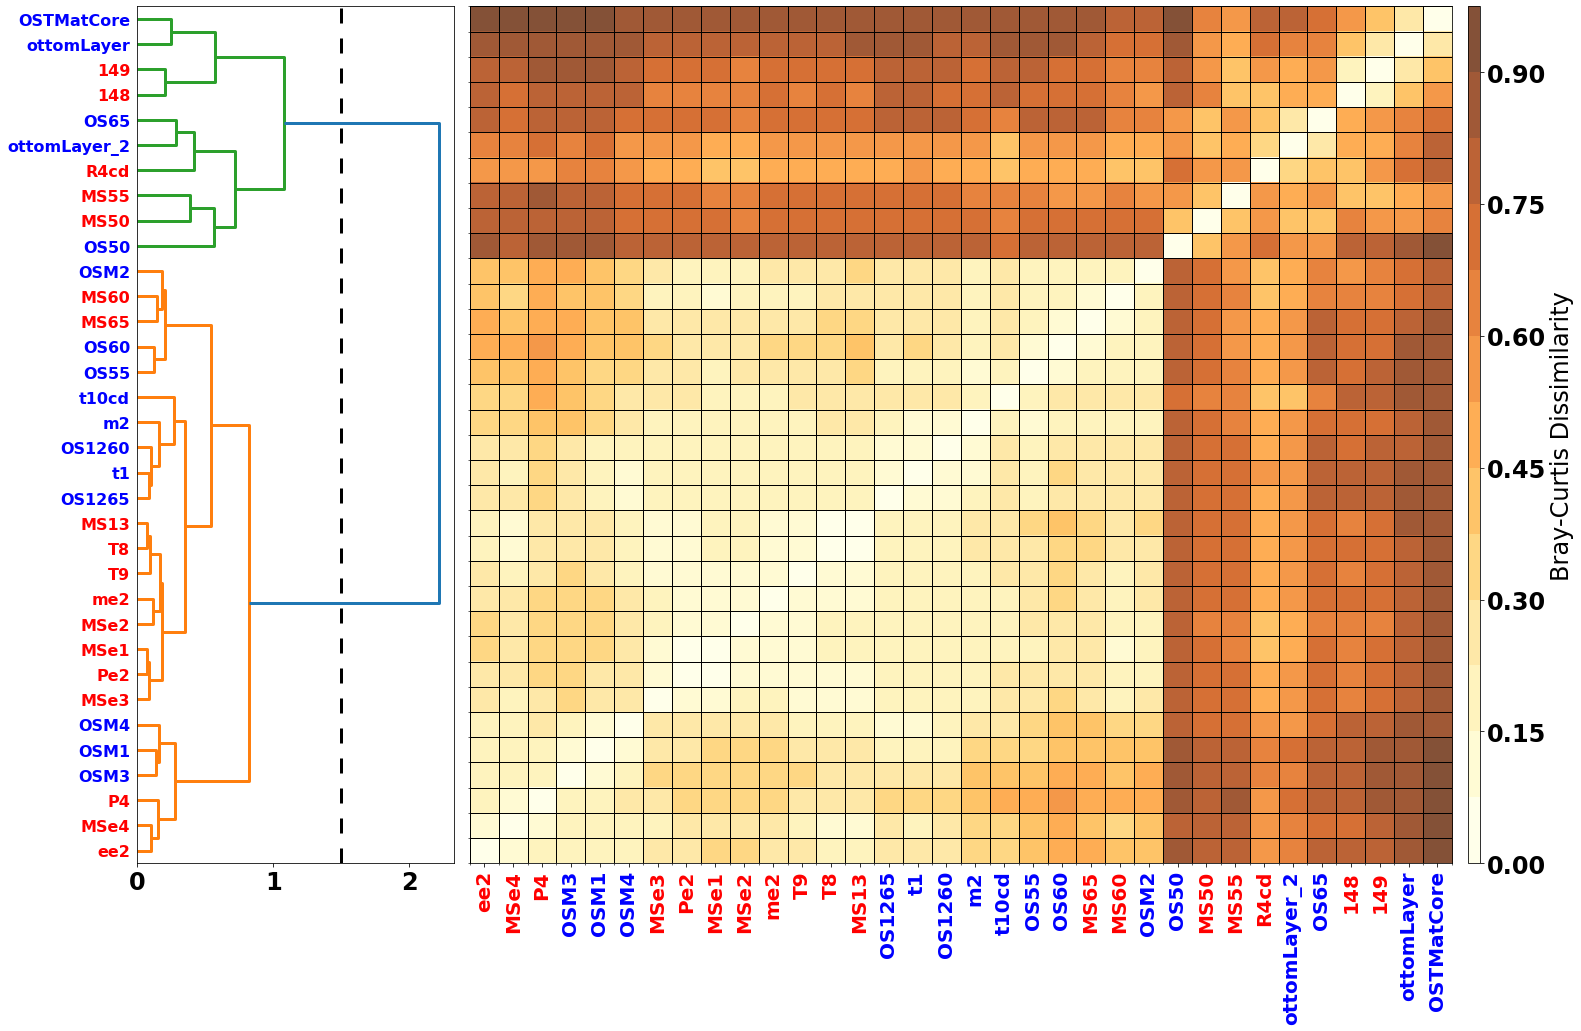

In [25]:
aero_coverage = data_dir+'Aerophilum/Read_alignments_novel_contigs/Summarized_Coverages/'
df_aero_eggnog = pd.read_excel(data_dir+'Aerophilum/Filtered.Eggnog.Annotations.xlsx')
representatives = df_aero_eggnog['RepresentativeContig'].unique().tolist()
Dist_Aerophilum, Feature_Aerophilum, index = Load_Coverage_Summary(aero_coverage, representatives, 0)
fig = Plot_Heatmap(Dist_Aerophilum, Feature_Aerophilum, index, sample_spring, 'ward', 0)

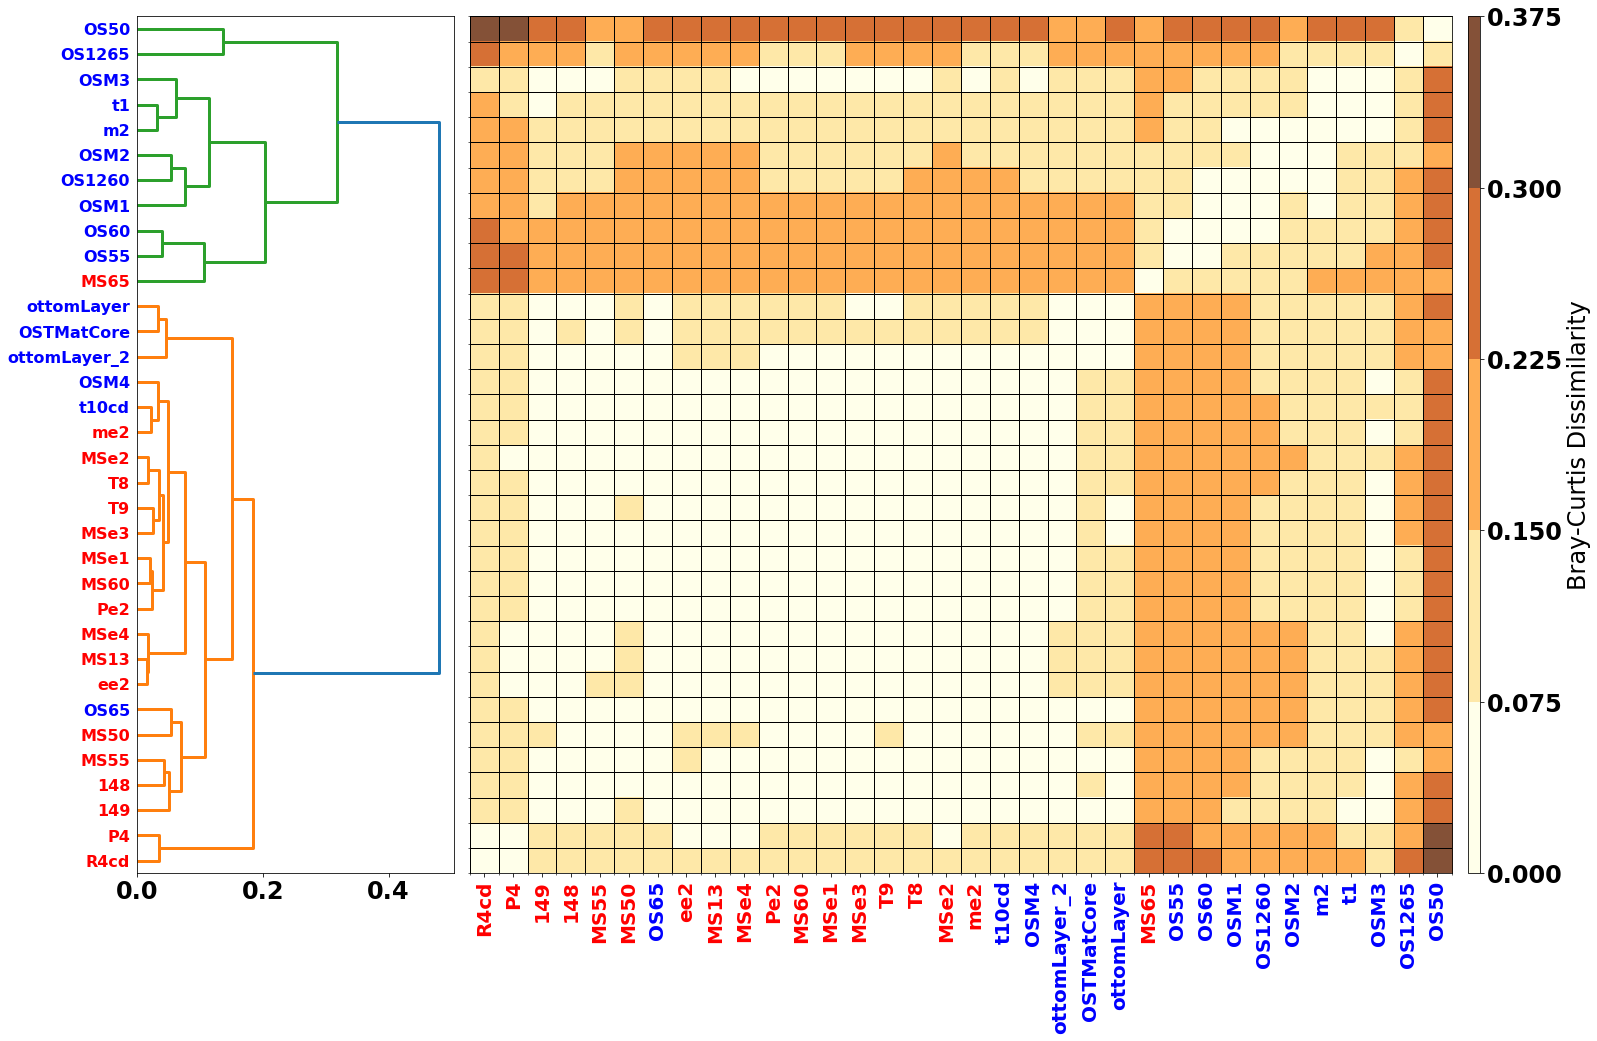

In [18]:
chlor_msg_coverage = data_dir+'Chloroflexus_MS_G/Read_alignments_novel_contigs/Summarized_Coverages/'
df_chlor_msg_eggnog = pd.read_excel(data_dir+'Chloroflexus_MS_G/Filtered.Eggnog.Annotations.xlsx')
representatives = df_chlor_msg_eggnog['RepresentativeContig'].unique().tolist()
Dist_Chloroflexus, Feature_Chloroflexus, index = Load_Coverage_Summary(chlor_msg_coverage, representatives, True)
fig = Plot_Heatmap(Dist_Chloroflexus, Feature_Chloroflexus, index, sample_spring, 'ward', False)

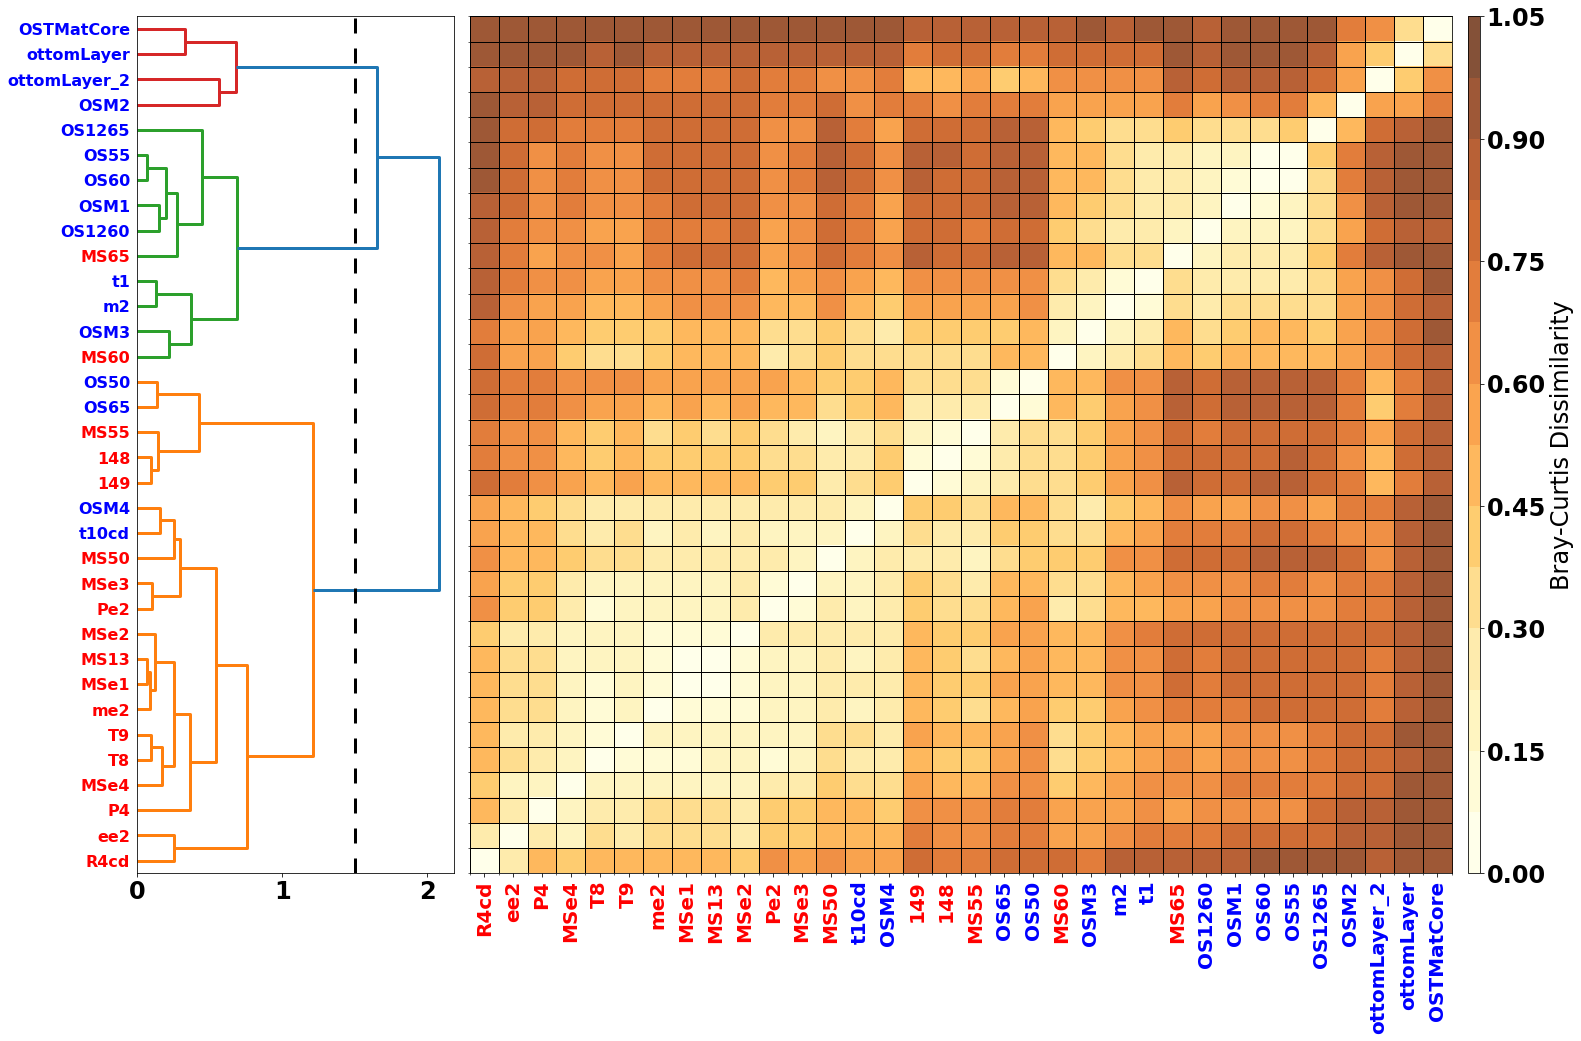

In [19]:
syn_coverage = data_dir+'Synechococcus/Read_alignments_novel_contigs/Summarized_Coverages/'
df_syn_eggnog = pd.read_excel(data_dir+'Synechococcus/Filtered.Eggnog.Annotations.xlsx')
representatives = df_syn_eggnog['RepresentativeContig'].unique().tolist()
Dist_Synechococcus,  Feature_Synechococcus, index = Load_Coverage_Summary(syn_coverage, representatives, 0)
fig = Plot_Heatmap(Dist_Synechococcus, Feature_Synechococcus, index, sample_spring, 'ward', 0)

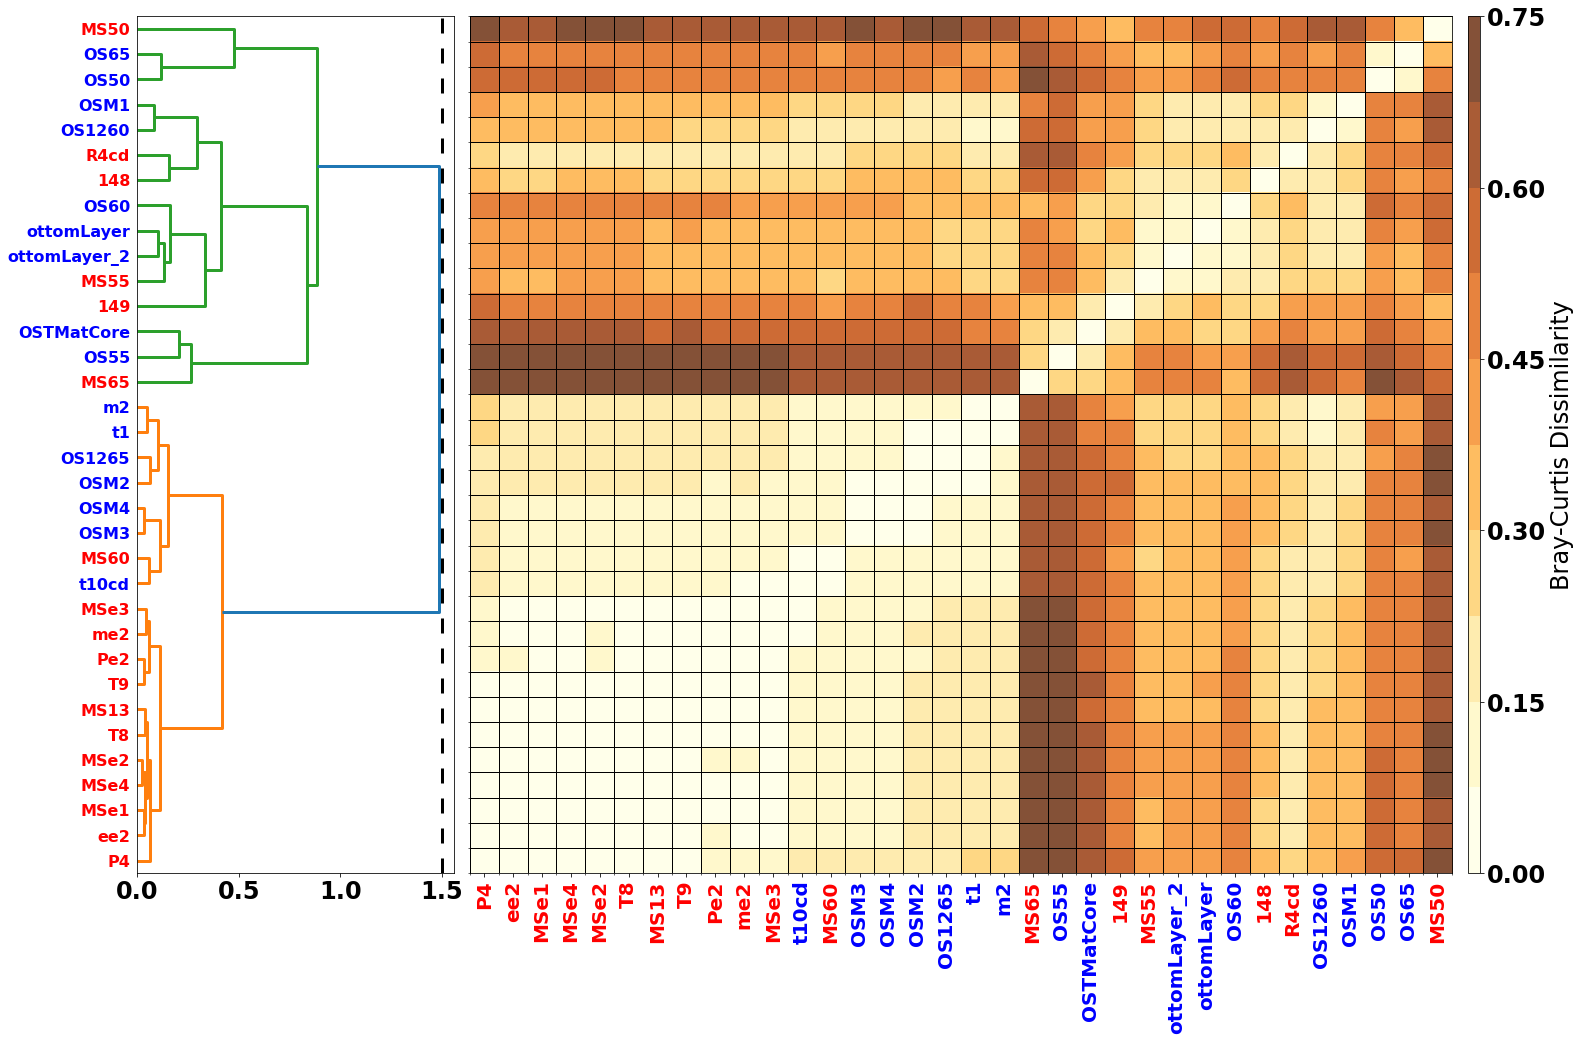

In [24]:
chloracidobacterium_coverage = data_dir+'Chloracidobacterium_thermophilum_B/Read_alignments_novel_contigs/Summarized_Coverages/'
df_chloracidobacterium_eggnog = pd.read_excel(data_dir+'Chloracidobacterium_thermophilum_B/Filtered.Eggnog.Annotations.xlsx')
representatives = df_chloracidobacterium_eggnog['RepresentativeContig'].unique().tolist()
Dist_Chloracidobacterium, Feature_Chloracidobacterium, index = Load_Coverage_Summary(chloracidobacterium_coverage,
                                                                                     representatives)
fig = Plot_Heatmap(Dist_Chloracidobacterium, Feature_Chloracidobacterium, index, sample_spring, 'ward', False)

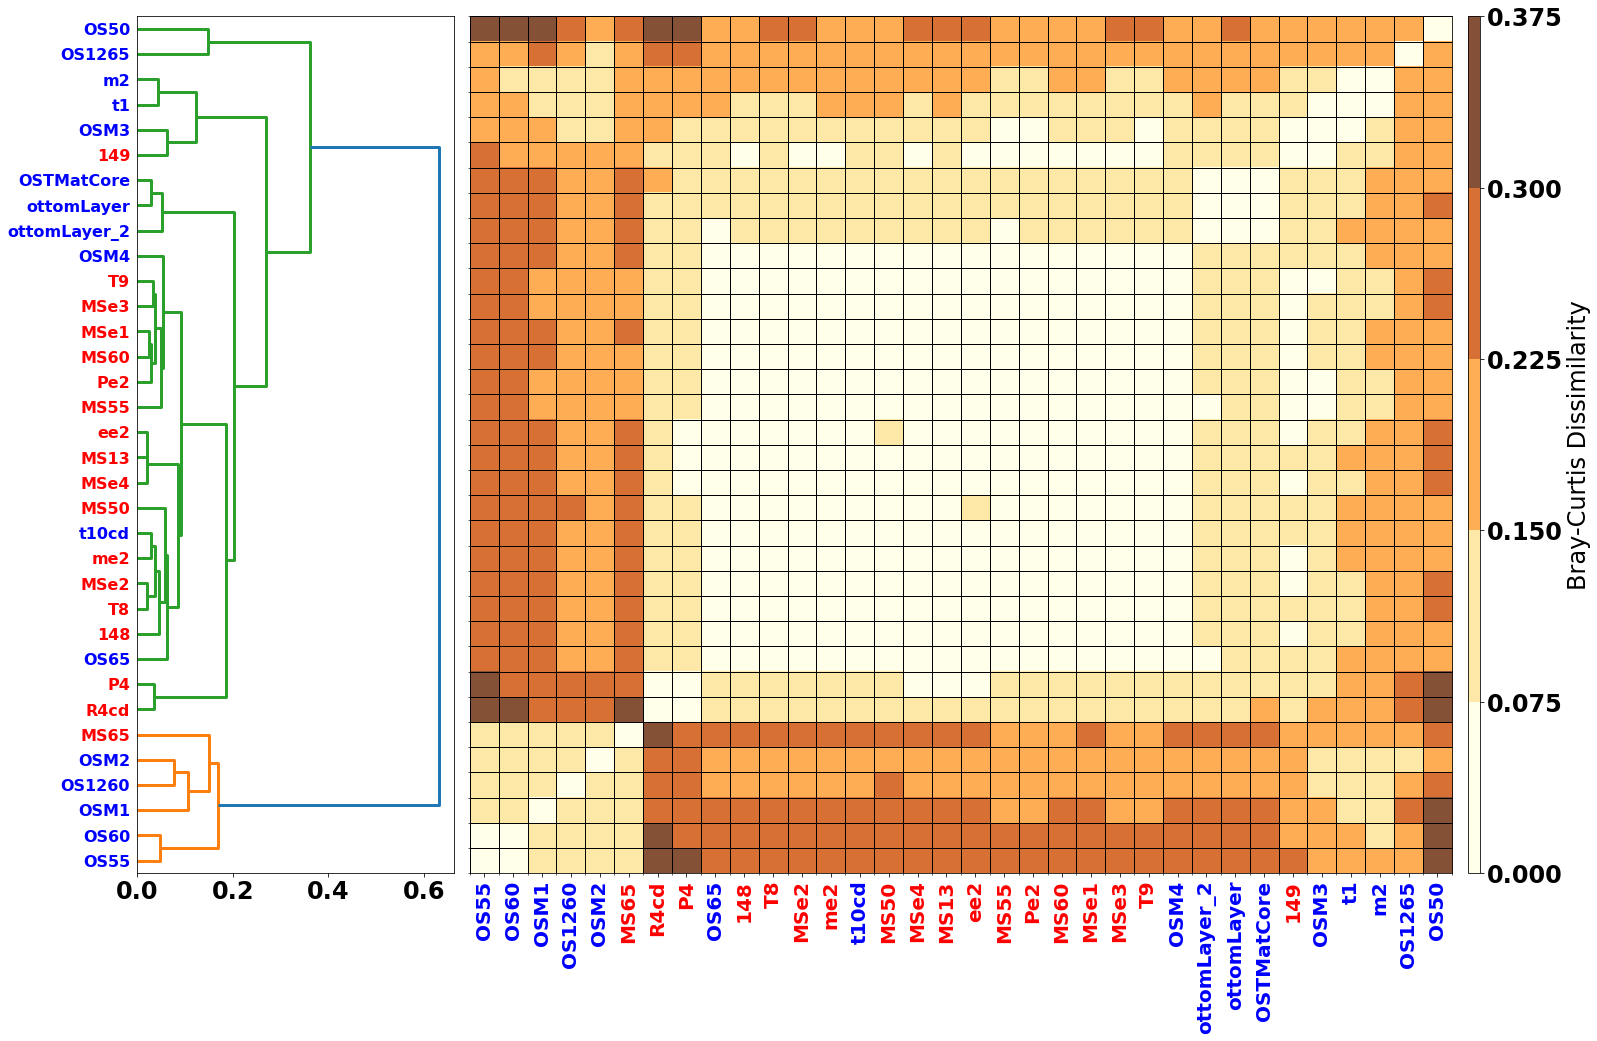

In [26]:
rosei_coverage = data_dir+'Roseiflexus/Read_alignments_novel_contigs/Summarized_Coverages/'
df_rosei_eggnog = pd.read_excel(data_dir+'Roseiflexus/Filtered.Eggnog.Annotations.xlsx')
representatives = df_rosei_eggnog['RepresentativeContig'].unique().tolist()
Dist_Roseiflexus, Feature_Roseiflexus,  index = Load_Coverage_Summary(rosei_coverage, representatives)
fig = Plot_Heatmap(Dist_Roseiflexus, Feature_Roseiflexus, index, sample_spring, 'ward', False)

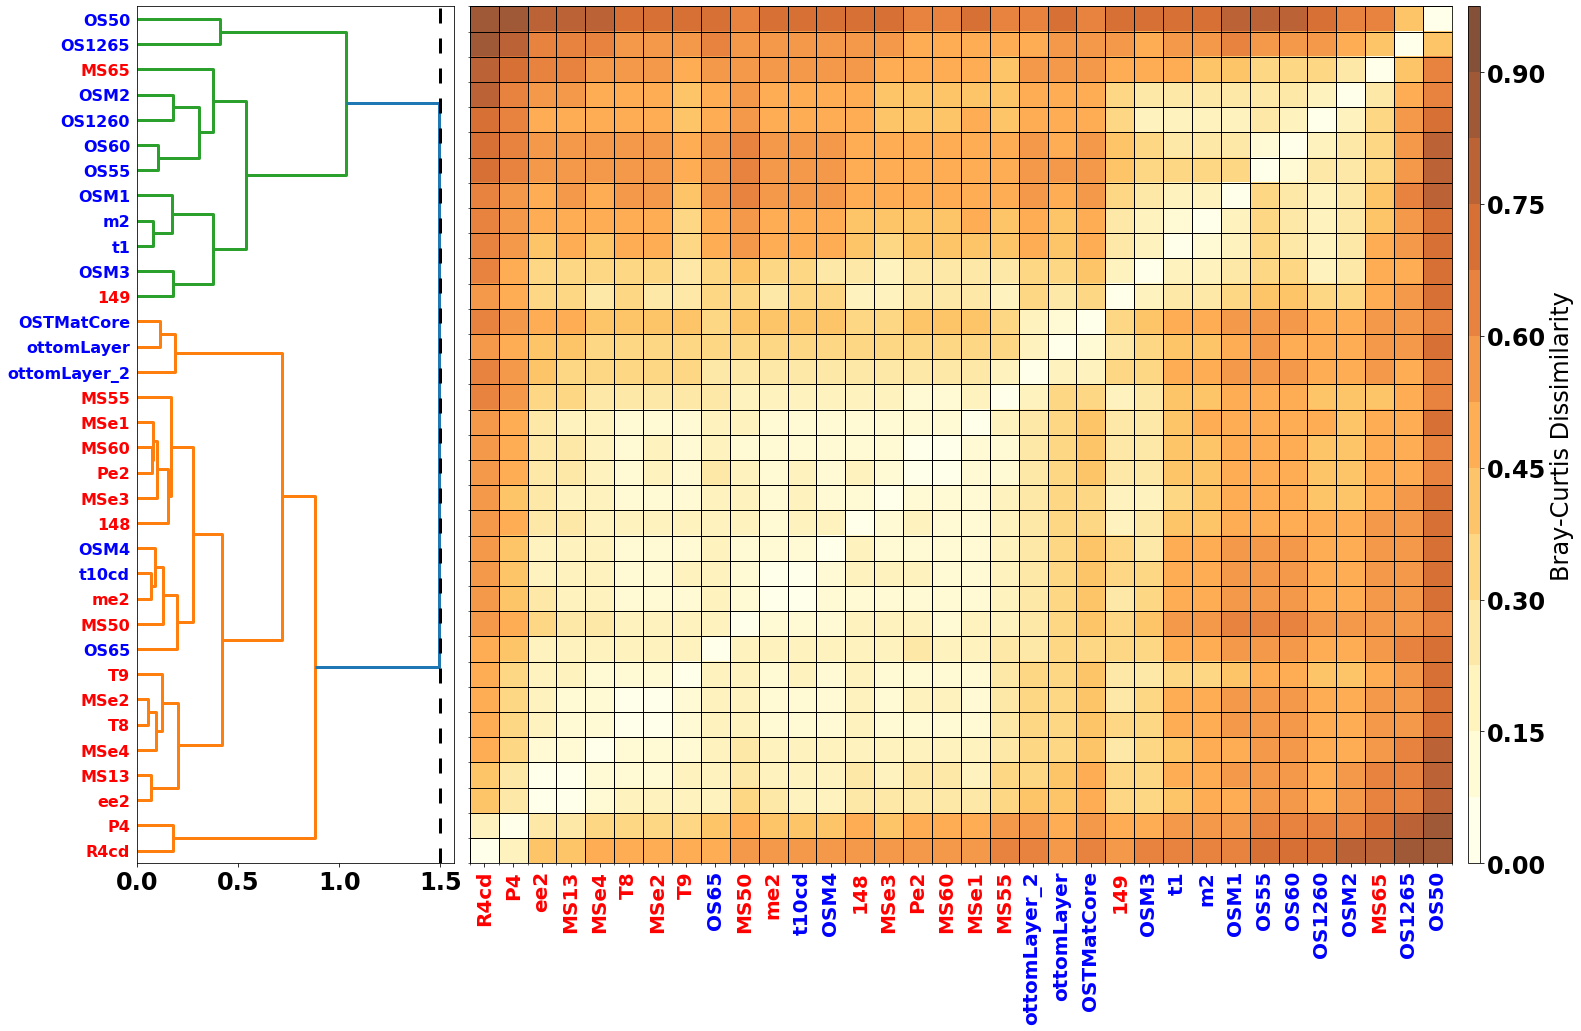

In [27]:
all_coverage = data_dir+'All_Genomes/Read_alignments_novel_contigs/Summarized_Coverages/'
df_all_eggnog = pd.read_excel(data_dir+'All_Genomes/Filtered.Eggnog.Annotations.xlsx')
representatives = df_all_eggnog['RepresentativeContig'].unique().tolist()
Dist_All, Feature_All, index = Load_Coverage_Summary(all_coverage, representatives, 0)
fig = Plot_Heatmap(Dist_All, Feature_All, index, sample_spring, 'ward', 0)
